In [9]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import geopandas as gpd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

np.random.seed(24) # 42

In [10]:
pkl_file = open('train_df.pkl', 'rb')
df = pickle.load(pkl_file)
pkl_file.close()

# From log_best to cm mu:

In [11]:
df = df.sort_values(['gid','year'])

In [12]:
def get_X_new(step_size = 0.25):
    step = step_size
    min_year = df['year'].min()
    max_year = df['year'].max()

    X_new = np.arange(min_year,max_year + step, step)[:,None]
    
    return(X_new)

In [13]:
def get_X_y_index():
    X = np.array(df['year'])[:,None]
    y = np.array(df['log_best'])
    index = np.array(df['gid'])
    
    return(X,y,index)

In [14]:
def get_gid_list():
    
    gid_list = []

    for i in df['gid'].unique():
        
        timeline  = df[df['gid'] == i]
        if np.count_nonzero(timeline['log_best']) >= 2:
            gid_list.append(i)
        
    gid_list = np.random.choice(gid_list, 100) # number of samples for hyper parameter estimates.
    
    return(gid_list)

In [15]:
def get_event_timelines():
    df_sub = df[df['gid'].isin(gid_list)].sort_values(['gid','year'])
    
    event_X = np.array(df_sub['year'])[:,None]
    event_y = np.array(df_sub['log_best'])
    event_index = np.array(df_sub['gid'])
    
    return(event_X, event_y, event_index)

In [16]:
X_new = get_X_new()
X,y,index = get_X_y_index()
gid_list = get_gid_list()
X1,y1,index1 = get_event_timelines()

# Viz

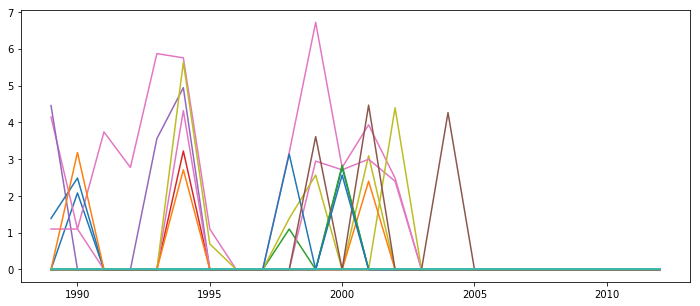

In [17]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index)[0:100]):
    plt.plot(X[index == j], y[index==j])
    
plt.show()


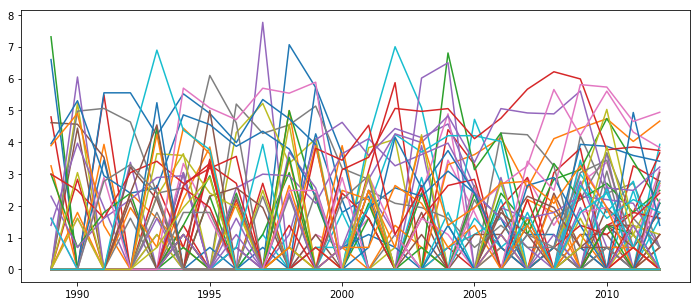

In [18]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index1)[0:100]):
    plt.plot(X1[index1 == j], y1[index1==j])
    
plt.show()

# Estimation
### Define and illlustrate hyper-priors:

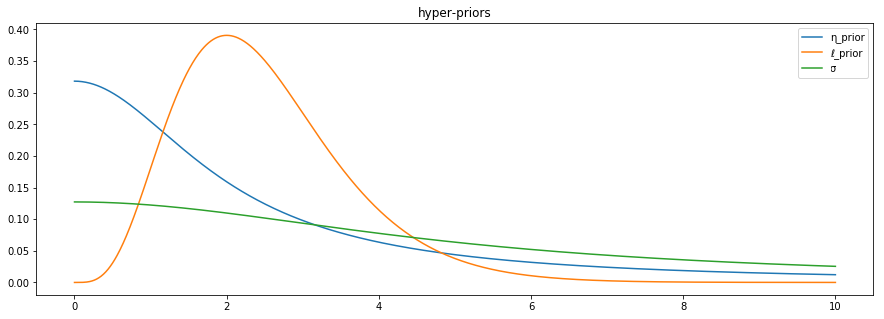

In [19]:
η_beta = 2
ℓ_beta = 2
ℓ_alpha = 5
σ_beta = 5

grid = np.linspace(0,10,1000)
priors = [
    ('η_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('ℓ_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('σ', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()

# from sce mu to dce mu model:

In [20]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
    
    # Cov func.
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov)

    
    # sample: 
    for i, j in enumerate(np.unique(index1)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
                
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X1[index1 == j], y=y1[index1 == j], noise= σ)
        

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [21]:
time1 = time.time()

with model:
    trace = pm.sample()
    
time1 = time.time()
stepallt = (time1 - time0)/60
print('time total: {}min'.format(stepallt))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexin

time total: 64.40067107280096min


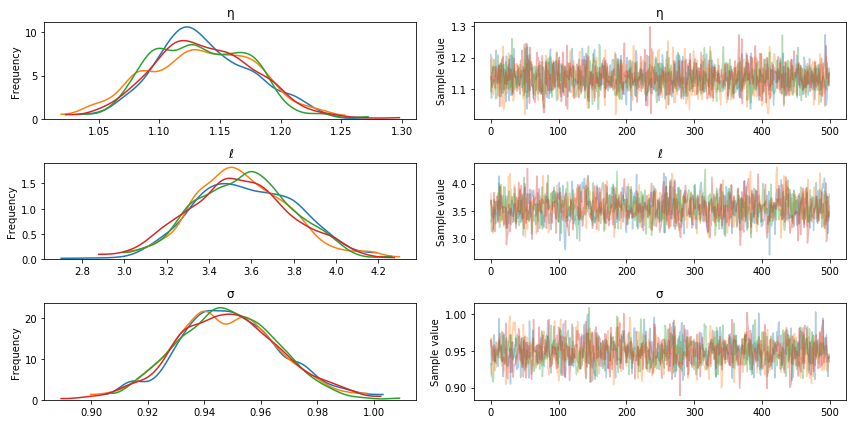

In [22]:
pm.traceplot(trace, varnames=['η', 'ℓ', 'σ'])
plt.show()

In [23]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,3.558865,0.236052,0.006610,3.081363,3.991922,1348.303486,1.000681
η__0,1.135721,0.042220,0.000827,1.055965,1.217768,2321.896649,0.999279
σ__0,0.948568,0.017949,0.000450,0.912593,0.982699,1537.916100,1.000170


In [24]:
mp = {'ℓ' : np.array([pm.summary(trace)['mean'].iloc[0]]),  
      'η': np.array([pm.summary(trace)['mean'].iloc[1]]), 
      'σ' : np.array([pm.summary(trace)['mean'].iloc[2]])}

mp

{'η': array([1.13572121]), 'σ': array([0.9485678]), 'ℓ': array([3.55886543])}

# Pickle

In [26]:
file_name = "cm_hp_trace_mu.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace, output)
output.close()

file_name = "cm_hp_mp_mu.pkl"
output = open(file_name, 'wb') 
pickle.dump(mp, output)
output.close()

# Pickle test

In [27]:
pkl_file = open('cm_hp_trace_mu.pkl', 'rb')
PT_cm_hp_trace_mu = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_hp_mp_mu.pkl', 'rb')
PT_cm_hp_mp_mu = pickle.load(pkl_file)
pkl_file.close()

In [28]:
pm.summary(PT_cm_hp_trace_mu)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,3.558865,0.236052,0.006610,3.081363,3.991922,1348.303486,1.000681
η__0,1.135721,0.042220,0.000827,1.055965,1.217768,2321.896649,0.999279
σ__0,0.948568,0.017949,0.000450,0.912593,0.982699,1537.916100,1.000170


In [29]:
PT_cm_hp_mp_mu

{'η': array([1.13572121]), 'σ': array([0.9485678]), 'ℓ': array([3.55886543])}